In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class MultiRBFnn(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnn, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features

        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target): 

        # input_data shape : (data_num)
        # target data shape : (in_feature, 1, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = target.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 2, center_index_list)[-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                
        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,:,k]).reshape(1))

        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num, 1)


        return initcenter, initweight, initsigma

    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2))) / (torch.pow(self.sigma, 2))

        return out
    
    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R).reshape(self.in_feature, 1, input_data.size(-1))

        return R, pred
    
    def rbf_gradient(self, input_data, C, S, W): 
        rbf_output = (-2 * (input_data - C) / torch.pow(S, 2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - C), 2) / (torch.pow(S, 2)))))
        rbf_grad = torch.mm(W, rbf_output)
        
        return rbf_grad.reshape(self.in_feature, 1, input_data.size(-1)) # (in_feature, 1, data_num)

    def first_grad(self, input_data, target): 
        space = (input_data,)
        ori_grad = torch.gradient(target, spacing = space, dim = 2, edge_order  = 1)
        return ori_grad[0] # (in_feature, 1, data_num)
        
    def target_grad(self, input_data, centers, sigmas, weights, ori_grad): 
        true_grad = ori_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
         
        return true_grad # (in_feature, 1, data_num)
    
    def predict(self, input_data): # ? 
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.mm(self.done_weights.reshape(self.in_feature, self.add_rbf_num),
                         rbf_output).reshape(self.in_feature, 1, input_data.size(-1))

        return rbf_output, pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value loss + gradient loss 

        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2))
    

    def L2_F(self, input_data): #done
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2) # (add_rbf_num, data_num)

    # partial derivative define

    def L2_2_derivative_weight(self, input_data, radial_output):
        return self.L2_F(input_data) * radial_output               # (add_rbf_num, data_num)

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # additional RBFs 
    def add_rbf_parameter(self, input_data, error):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 2, center_index_list)[:,:,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft = (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,:,k]).reshape(1))
        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)

        return initcenter, initweight, initsigma
    
    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                     (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight.reshape(self.in_feature, self.add_rbf_num), 
                        rbf_output).reshape(self.in_feature, 1, input_data.size(-1))

        return rbf_output, pred

    def backward_propagation(self, input_data, R, pred, target, target_grad, pred_grad):
        
        L2_1_error = -2 * (target - pred)
        L2_2_error = -2 * (target_grad - pred_grad)

        # updata partial derivative
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error                       # (in_feature, add_rbf_num, data_num)
        deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)                   # (in_feature, add_rbf_num, data_num)

        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error                       # (in_feature, add_rbf_num, data_num)
        deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)    # (in_feature, add_rbf_num, data_num)

        deltaSigma =  torch.sum(torch.sum(deltaSigma1, dim=2), dim = 0) + torch.sum(torch.sum(deltaSigma2, dim=2), dim = 0) # (add_rbf_num) 

        # center partial derivative
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error
        deltaCenter1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
        
        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error
        deltaCenter2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaCenter =  torch.sum(torch.sum(deltaCenter1, dim=2),dim =0) + torch.sum(torch.sum(deltaCenter2, dim=2), dim = 0) # (add_rbf_num)


        # weight partial derivative
        delta_weight1 = torch.sum((R * L2_1_error), dim=2)        # (in_feature, add_rbf_num)
        delta_weight2 = torch.sum((self.L2_2_derivative_weight(input_data, R) * L2_2_error), dim = 2) # (in_feature, add_rbf_num)
        delta_weight = delta_weight1 + delta_weight2 # (in_feature, add_rbf_num)

        # BP update
        self.weights -= self.lr * delta_weight
        self.centers -= self.lr * deltaCenter.reshape(self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.add_rbf_num, 1)

    def plot_train(self, input_data, best_pred): #done
        fig, ax = plt.subplots(1, 3, figsize = (30, 5))
        for i in range(self.in_feature):
            ax[i].plot(input_data.cpu().detach().numpy(), self.target[i][0].cpu().detach().numpy())
            ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i][0].cpu().detach().numpy())
        plt.show()

    def train(self, input_data, target, epochs, lr, loss_th):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.change_time = 0

        break_time = len(input_data) / self.add_rbf_num
        # count_loss_chage = 0
        # count_round_change = 0

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, self.target)
                first_grad = self.first_grad(input_data, target)

                for epoch in range(epochs):
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)

                    self.backward_propagation(input_data, R, pred, self.target, first_grad, rbf_grad)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 250 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, self.target)

                for epoch in range(epochs):
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                     self.Loss(pred, self.target, rbf_grad, target_grad)))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.backward_propagation(input_data, R, pred, self.target, first_grad, rbf_grad)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epoch + 1) % 250 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                
            best_R, best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)

            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print("{}th additional RBFlayer best loss : ".format(self.number, train_loss))
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                target_grad = self.target_grad(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)
            else:
                na = 0

In [6]:
import numpy as np
a = np.arange(0,10,0.05)
    
y = 2*a**3 - 16*a**2 + 2*a -10
y2 = 3*a**2 -16*a - 30
y3 = 5*a**2 +25*a - a**3

target = np.array((y,y2,y3))
target = torch.tensor(target, device = device).reshape((3,1,200))
input_ = torch.tensor(a, device = device)

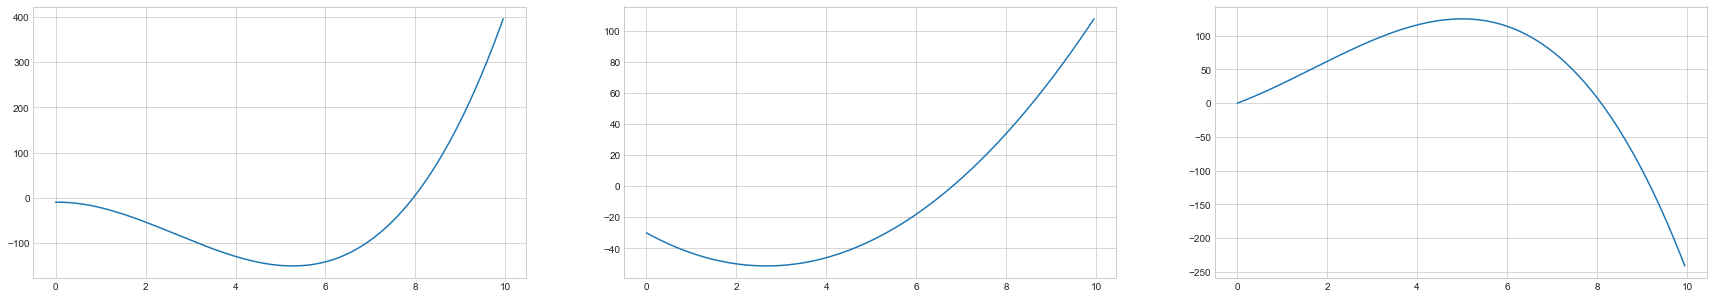

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
for i in range(3):
    ax[i].plot(input_.cpu().detach().numpy(), target[i][0].cpu().detach().numpy())

plt.show()

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 3956479.1602173317
0th additional RBFlayer 249th epoch MSE Loss: 164974.77532891012
0th additional RBFlayer 499th epoch MSE Loss: 162576.21801166667
0th additional RBFlayer 749th epoch MSE Loss: 157799.59947301244
0th additional RBFlayer 999th epoch MSE Loss: 152882.5052643862
0th additional RBFlayer 1249th epoch MSE Loss: 148122.46271023818
0th additional RBFlayer 1499th epoch MSE Loss: 143624.55332045944
0th additional RBFlayer 1749th epoch MSE Loss: 139436.2316157243
0th additional RBFlayer 1999th epoch MSE Loss: 135561.85558198256
0th additional RBFlayer 2249th epoch MSE Loss: 131987.57443862758
0th additional RBFlayer 2499th epoch MSE Loss: 138484.44633730364
0th additional RBFlayer 2749th epoch MSE Loss: 135372.42509759337
0th additional RBFlayer 2999th epoch MSE Loss: 132490.17298686024
0th additional RBFlayer 3249th epoch MSE Loss: 129817.93491704177
0th additional RBFlayer 3499th epoch MSE Loss: 127338.3839970324


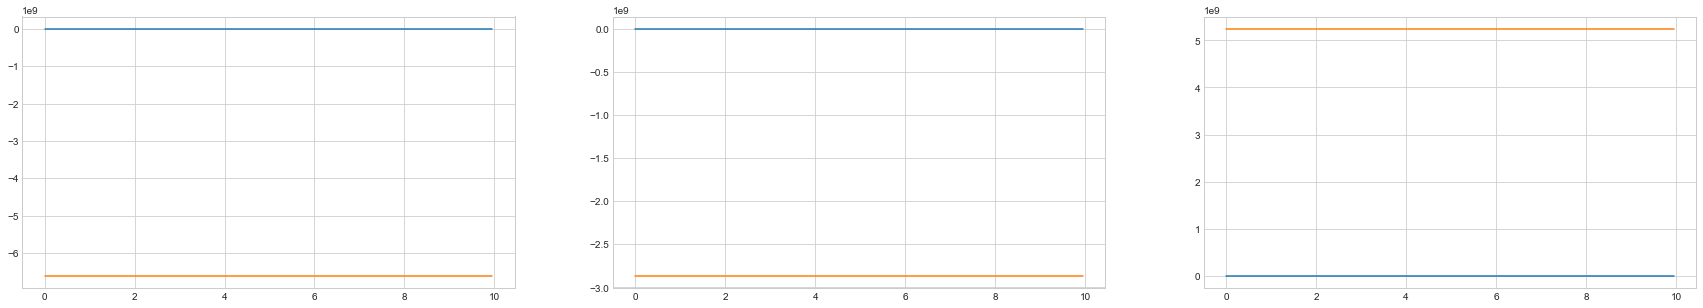

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 4.975255163825177e+21
1th additional RBFlayer 249th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 499th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 749th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 999th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 1249th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 1499th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 1749th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 1999th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 2249th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 2499th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 2749th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 2999th epoch MSE Loss: 2.6506776590693077e+19
1th additional RBFlayer 3249th epoch MSE Loss: 2.6506776590693077e+19
1th addi

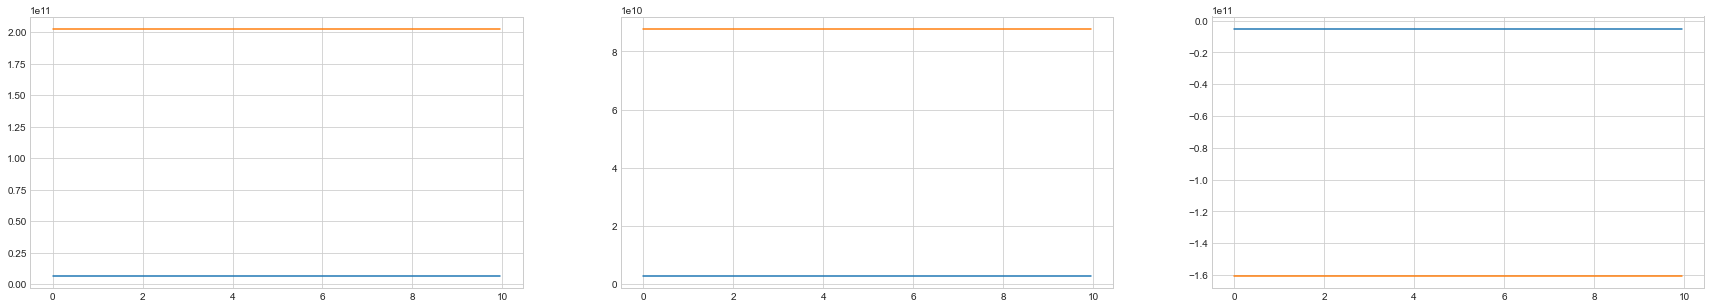

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 4.445166246129613e+24
2th additional RBFlayer 249th epoch MSE Loss: 2.324332501702462e+22
2th additional RBFlayer 499th epoch MSE Loss: 2.324332501702462e+22
2th additional RBFlayer 749th epoch MSE Loss: 2.324332501702462e+22
2th additional RBFlayer 999th epoch MSE Loss: 2.324332501702462e+22
2th additional RBFlayer 1249th epoch MSE Loss: 2.324332501702462e+22
2th additional RBFlayer 1499th epoch MSE Loss: 2.324332501702462e+22
2th additional RBFlayer 1749th epoch MSE Loss: 2.324332501702462e+22


KeyboardInterrupt: 

In [8]:
model = MultiRBFnn(target.size(0), 200, device)
model.train(input_, target, 5000, 1e-05, 10)

In [79]:
A = torch.rand((3,5,200))

In [86]:
torch.sum(A[0], dim =1)

tensor([ 99.6885, 100.8150, 103.4974,  96.0597, 102.6519])

In [89]:
torch.sum(torch.sum(A, dim = 2), dim = 0)

tensor([312.6989, 295.5632, 294.0472, 291.4388, 294.4698])